In [2]:
# Setup & imports

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import gaussian
from sklearn.preprocessing import StandardScaler
import pickle

# Set plotting styles
sns.set(style="whitegrid")
plt.rcParams['font.family'] = ['Heiti TC']  # For displaying Chinese characters if needed

## Data Loading

In [3]:
# Read the metadata CSV
list_info = pd.read_csv('./stimuli/list_info.csv')
list_info.head()

,Word,checklist,token,token_trial,word,bopomofo,consonant,vowel,block
0,易 ㄧˋ,True,isolate_i_4,isolate_i_4_rep1,易,ㄧˋ,isolate,i,4
1,孜 ㄗ,True,z_apical_1,z_apical_1_rep1,孜,ㄗ,z,apical,1
2,都 ㄉㄨ,True,d_u_1,d_u_1_rep1,都,ㄉㄨ,d,u,1
3,車 ㄔㄜ,True,ch_schwa_1,ch_schwa_1_rep1,車,ㄔㄜ,ch,schwa,1
4,舒 ㄕㄨ,True,sh_u_1,sh_u_1_rep1,舒,ㄕㄨ,sh,u,1


## Image Processing

### 1. Loading & Cropping Images

Define a function to load images from a specified folder, crop them to focus on the region of interest, convert them to grayscale, and resize for uniformity.

In [4]:
def load_process_images(image_folder, crop=True, do_resize=True, resize_prop=0.2):
    """
    Loads and preprocesses images from a folder.
    
    Parameters:
    - image_folder (str): Path to the folder containing images.
    - crop (bool): Whether to crop the images.
    - do_resize (bool): Whether to resize the images.
    - resize_prop (float): Proportion to resize the images by.
    
    Returns:
    - dict: Dictionary with image labels as keys and preprocessed images as numpy arrays.
    """
    image_dict = {}
    file_list = [file for file in os.listdir(image_folder) if file.endswith('.png')]
    
    for file_name in file_list:
        file_path = os.path.join(image_folder, file_name)
        image_array = plt.imread(file_path)
        
        # Crop the image if specified
        if crop:
            image_array = image_array[100:400, 150:525]
        
        # Convert to grayscale
        image_array = rgb2gray(image_array)
        
        # Resize the image if specified
        if do_resize:
            height, width = int(image_array.shape[0] * resize_prop), int(image_array.shape[1] * resize_prop)
            image_array = resize(image_array, (height, width), anti_aliasing=True)
        
        # Store the processed image
        label = file_name[:-4]  # Remove '.png' extension
        image_dict[label] = image_array
    
    return image_dict

# Load and preprocess vowel images
vowel_images = load_process_images('./vowel_clusters_streamlit/vowel_frames')


### 2. Visualizing an Example Image

Display an example of the preprocessed image to verify the preprocessing steps.

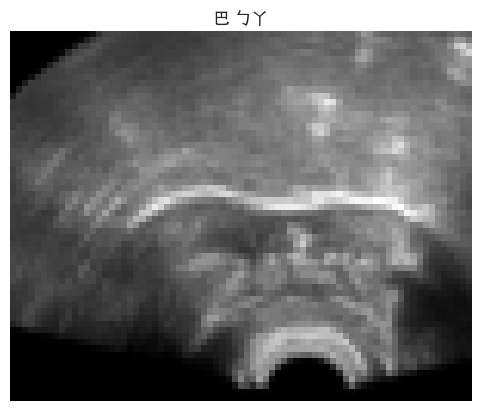

In [5]:
def show_image(image, title='Image', cmap_type='gray'):
    """
    Displays an image with a title.
    
    Parameters:
    - image (numpy array): Image data.
    - title (str): Title of the image.
    - cmap_type (str): Colormap type.
    """
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show an example image
show_image(vowel_images['b_a_1_rep1'], "巴 ㄅㄚ")


### 3. Applying Gaussian Filter

Apply Gaussian filtering to reduce noise and smooth the images, which can enhance clustering performance.

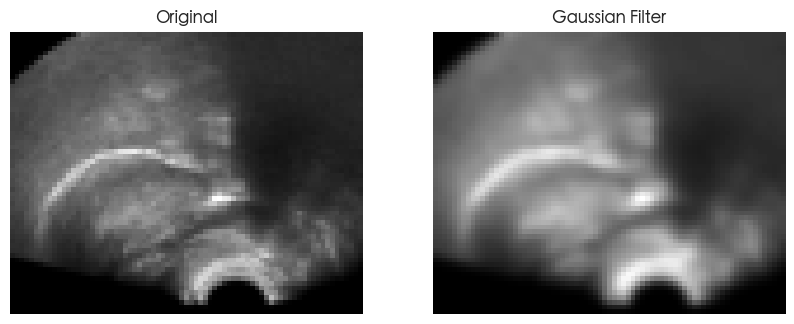

In [6]:
def plot_comparison(original, filtered, title_filtered):
    """
    Plots original and filtered images side by side for comparison.
    
    Parameters:
    - original (numpy array): Original image.
    - filtered (numpy array): Filtered image.
    - title_filtered (str): Title for the filtered image.
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap='gray')
    ax2.set_title(title_filtered)
    ax2.axis('off')
    plt.show()

# Apply Gaussian filter to a sample image
gaussian_image_cu2 = gaussian(vowel_images['c_u_2_rep10'])
plot_comparison(vowel_images['c_u_2_rep10'], gaussian_image_cu2, 'Gaussian Filter')

# Apply Gaussian filter to all images
gaussian_images = {name: gaussian(image) for name, image in vowel_images.items()}


## Flattening Images

Convert each 2D image into a 1D array to prepare the data for clustering algorithms.

In [7]:
def flatten_images(image_dict):
    """
    Flattens all images in the image dictionary.
    
    Parameters:
    - image_dict (dict): Dictionary with image labels as keys and image arrays as values.
    
    Returns:
    - dict: Dictionary with 'label' and 'pixels' keys.
    """
    flattened_images = {'label': [], 'pixels': []}
    for label, image in image_dict.items():
        flattened_images['label'].append(label)
        flattened_images['pixels'].append(image.flatten())
    return flattened_images

# Flatten original and Gaussian-filtered images
flattened_image_dict = flatten_images(vowel_images)
flattened_gaussian_image_dict = flatten_images(gaussian_images)

# Convert to DataFrames
image_df = pd.DataFrame(flattened_image_dict)
gaussian_image_df = pd.DataFrame(flattened_gaussian_image_dict)


## Data Scaling

Standardize the pixel data to have zero mean and unit variance, which is essential for many machine learning algorithms.

In [8]:
# Initialize StandardScaler
scaler = StandardScaler()

# Stack the pixel arrays vertically into a 2D array
pixel_data = np.vstack(image_df['pixels'].values)  # Shape: (2700, 4500)

# Fit the scaler to the pixel data and transform
scaled_pixel_data = scaler.fit_transform(pixel_data)

# Add the scaled pixels to the DataFrame
image_df['scaled_pixels'] = list(scaled_pixel_data)

## Merging with Metadata

Combine the preprocessed image data with the corresponding metadata.

In [9]:
# Merge the image DataFrame with metadata
merged_df = pd.merge(image_df, list_info, left_on='label', right_on='token_trial', how='inner')

# Display the first few rows of the merged DataFrame
merged_df.head()

,label,pixels,scaled_pixels,Word,checklist,token,token_trial,word,bopomofo,consonant,vowel,block
0,r_u_4_rep1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.21...",入 ㄖㄨˋ,True,r_u_4,r_u_4_rep1,入,ㄖㄨˋ,r,u,4
1,ch_apical_2_rep1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.21...",池 ㄔˊ,True,ch_apical_2,ch_apical_2_rep1,池,ㄔˊ,ch,apical,2
2,ch_apical_3_rep1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.21...",恥 ㄔˇ,True,ch_apical_3,ch_apical_3_rep1,恥,ㄔˇ,ch,apical,3
3,sh_a_1_rep1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.21...",沙 ㄕㄚ,True,sh_a_1,sh_a_1_rep1,沙,ㄕㄚ,sh,a,1
4,ch_schwa_1_rep1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.21...",車 ㄔㄜ,True,ch_schwa_1,ch_schwa_1_rep1,車,ㄔㄜ,ch,schwa,1


## Visualization

Plot the distribution of pixel intensities before and after Gaussian filtering to assess the effect of preprocessing.

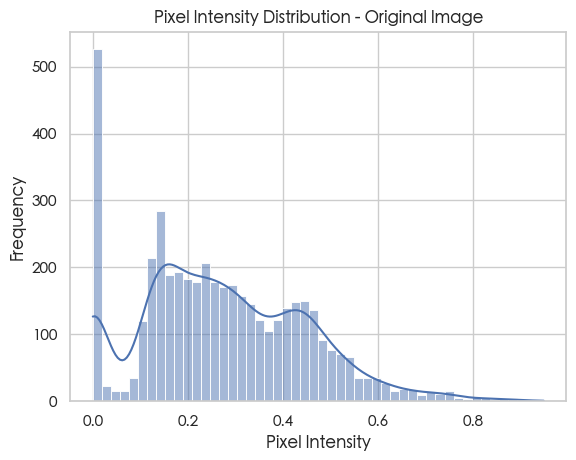

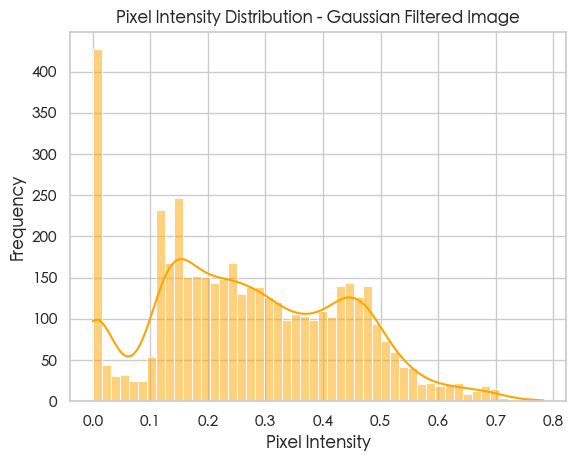

In [10]:
# Distribution before filtering
sns.histplot(image_df['pixels'][0], bins=50, kde=True)
plt.title('Pixel Intensity Distribution - Original Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Distribution after filtering
sns.histplot(gaussian_image_df['pixels'][0], bins=50, kde=True, color='orange')
plt.title('Pixel Intensity Distribution - Gaussian Filtered Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

## Exporting Preprocessed Data

Save the preprocessed data to disk to avoid reprocessing in future analyses.

In [11]:
# Define paths to save the preprocessed data
preprocessed_data_path = './preprocessed_data'
os.makedirs(preprocessed_data_path, exist_ok=True)

# Save the original and Gaussian-filtered DataFrames
image_df.to_pickle(os.path.join(preprocessed_data_path, 'original_image_df.pkl'))
gaussian_image_df.to_pickle(os.path.join(preprocessed_data_path, 'gaussian_image_df.pkl'))

# Save the merged DataFrame
merged_df.to_pickle(os.path.join(preprocessed_data_path, 'merged_df.pkl'))

# Optionally, save the scaler for future scaling of new data
with open(os.path.join(preprocessed_data_path, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print("Preprocessed data has been successfully exported.")

Preprocessed data has been successfully exported.
